# LegacyHalos SersicFitting

This notebook demonstrates how we fit the 1D surface brightness profiles using various parametric (e.g., Sersic) models, using one galaxy as a toy example.

### Imports, paths, and other preliminaries.

In [1]:
import os, pdb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from legacyhalos import io
from legacyhalos.ellipse import ellipse_sbprofile
from legacyhalos.qa import display_ellipse_sbprofile, display_sersic
from legacyhalos.sersic import SersicSingleWaveModel, SersicSingleWaveFit

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.4, palette='Set2')
%matplotlib inline

### Test on real data

Read a surface brightness profile and fit it.

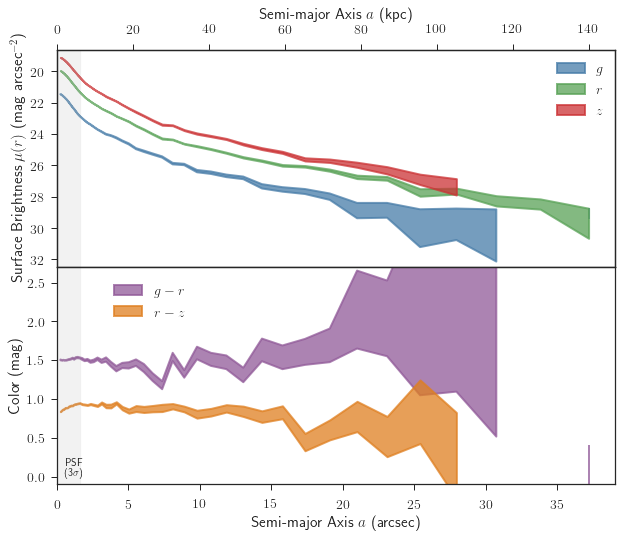

In [4]:
sample = io.read_sample(first=0, last=0)
objid, objdir = io.get_objid(sample)
ellipsefit = io.read_ellipsefit(objid, objdir)
sbprofile = ellipse_sbprofile(ellipsefit)
display_ellipse_sbprofile(ellipsefit)

In [5]:
sersic = SersicSingleWaveFit(ellipsefit, seed=1).fit(verbose=True)

/usr/local/anaconda3/envs/legacyhalos/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/anaconda3/envs/legacyhalos/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/anaconda3/envs/legacyhalos/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/anaconda3/envs/legacyhalos/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


SINGLE Sersic fitting succeeded with a chi^2 minimum of 98.36


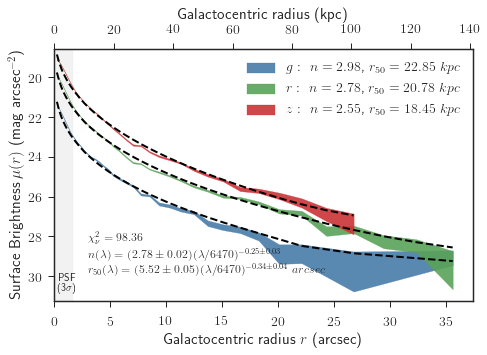

In [8]:
display_sersic(sersic)

In [9]:
sersic['phot']

flux_obs_g,flux_obs_r,flux_obs_z,flux_g,flux_r,flux_z,dm_in_g,dm_in_r,dm_in_z,dm_out_g,dm_out_r,dm_out_z,dm_g,dm_r,dm_z
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
53.8397,220.47,465.65,58.4242,233.775,485.795,0.016531,0.015327,0.0161766,0.0788401,0.0515044,0.0313647,0.0966265,0.0675815,0.0480191


In [7]:
stop

NameError: name 'stop' is not defined

#### Simulate a data set and plot it

Create a "galaxy" with a g-, r-, and z-band surface brightness profile measured over different radii.  Choose the Sersic index to vary with wavelength as $\beta=0.1$ with $n_{ref}=2.8$, and the half-light radius to vary as $\alpha=-0.2$ with $r_{ref}=8$ kpc.

In [ ]:
def simulate_sbprofiles(errfactor=0.2, seed=None, psfsigma=2.0, 
                        verbose=False, uniform_radius=True):
    """Simple script to simulate grz surface brightness profiles."""
    # instantiate a nominal model
    model = SersicSingleWaveModel(beta=0.1, alpha=-0.2, r50ref=8, nref=2.8, 
                                  mu50_g=0.5, mu50_r=1.0, mu50_z=1.5,
                                  psfsigma_g=psfsigma, psfsigma_r=psfsigma, 
                                  psfsigma_z=psfsigma)
    if verbose:
        print(model)

    rand = np.random.RandomState(seed)

    minradius = 0.02
    maxradius = 15.0
    nrad = (95, 89, 92) # number of measurements per bandpass g, r, z

    # build the wavelength and radius vector
    radius = []
    wave = []
    for lam, nn in zip( (model.lambda_g, model.lambda_r, model.lambda_z), nrad ):
        # uniform sampling makes the PSF convolution smoother
        if uniform_radius:
            rad = np.linspace(minradius, maxradius, nn) 
        else:
            rad = np.sort(rand.uniform(minradius, maxradius, nn))

        radius.append(rad)
        wave.append(np.repeat(lam, nn))
        
    radius = np.hstack(radius)
    wave = np.hstack(wave)

    # evaluate the model and add variance
    sb = model(radius, wave)
    sberr = rand.normal(loc=0, scale=sb*errfactor)
    #sberr = np.zeros_like(sb)
    #for ii in range(len(sb)):
    #    sberr[ii] = rand.normal(loc=0, scale=sb[ii]*errfactor)
    sb += sberr
    
    sersic = dict({'success': False, 'radius': radius, 
                   'wave': wave, 'sb': sb, 'sberr': sberr,
                   'band': model.band, 'pixscale': 1.0,
                   'lambda_g': model.lambda_g, 'lambda_r': model.lambda_r, 
                   'lambda_z': model.lambda_z})
    return sersic

In [ ]:
for sig in (0, 1, 2):
    sersic = simulate_sbprofiles(seed=1, errfactor=0.1, psfsigma=sig, uniform_radius=False)
    display_sersic(sersic)